# Description

In [1]:
# TODO(Paul): consider merging (or factoring out common code) with the `Master_research_backtest_analyzer` and `Master_execution_analysis`.

The notebook:
   - Loads results of a historical simulation
   - Computes research portfolio
   - Saves trades and pnl to a file
   - Performs prices and pnl cross-checks

The code overlaps with that from:
   - the `dataflow/model/notebooks/Master_research_backtest_analyzer.ipynb`: load tiled simulation, compute research pnl
   - the `oms/notebooks/Master_execution_analysis.ipynb`: load and resmaple OHLCV prices

What is really unique in the current notebook is:
   - Converting `holdings_shares` to `target_holdings_shares`
   - Saving data to a file
   - Prices and pnl cross-checks

# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime
import logging
import os

import pandas as pd

import core.config as cconfig
import core.plotting as coplotti
import dataflow.model as dtfmod
import dataflow_amp.system.Cx as dtfamsysc
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hparquet as hparque
import helpers.hprint as hprint
import im_v2.common.universe as ivcu

# TODO(Grisha): probably `dataflow/model` should not depend on `oms`.
import oms.broker.ccxt.ccxt_utils as obccccut

/app/amp/core/explore.py:39: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tauton


In [3]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-086aae51-dc7d-4e0e-804f-aad28b5c4f84.json'
-----------------------------------------------------------------------------
This code is not in sync with the container:
code_version='1.4.2' != container_version='1.6.0'
-----------------------------------------------------------------------------
You need to:
- merge origin/master into your branch with `invoke git_merge_master`
- pull the latest container with `invoke docker_pull`
INFO  # Git
  branch_name='CmTask5043_move_load_and_resample_ohlcv_data_to_a_lib'
  hash='d462e6c32'
  # Last commits:
    *   d462e6c32 Samarth  Merge branch 'CmTask5043_move_load_and_resample_ohlcv_data_to_a_lib' of github.com:cryptokaizen/cmamp into CmTask5043_move_load_and_resample_ohlcv_data_to_a_lib (62 minutes ago) Mon Aug 21 15:57:15 2023  (HEAD -> CmTask5043_move_load_and_resample_ohlcv_data_to_a_lib)
    |\  
    | * 14548e599 Nina Lee linte

# Build the config

In [4]:
market_info = obccccut.load_market_data_info()
asset_id_to_share_decimals = obccccut.subset_market_info(
    market_info, "amount_precision"
)
asset_id_to_share_decimals

{6051632686: 0,
 8717633868: 0,
 2540896331: 0,
 1528092593: 0,
 8968126878: 2,
 1467591036: 3,
 2476706208: 1,
 5115052901: 0,
 3065029174: 0,
 1891737434: 1,
 3401245610: 1,
 1464553467: 3,
 1966583502: 0,
 1030828978: 0,
 2601760471: 2,
 2683705052: 0,
 9872743573: 0,
 2484635488: 0,
 2099673105: 0,
 4516629366: 0,
 2237530510: 0,
 2425308589: 0,
 1776791608: 1,
 2384892553: 1,
 5118394986: 1}

In [35]:
config = {
    "dir_name": "/shared_data/model/historical/build_tile_configs.C5b.ccxt_v7_1-all.5T.2019-10-01_2023-07-02.ins.run0/tiled_results",
    "start_date": datetime.date(2022, 7, 2),
    "end_date": datetime.date(2023, 7, 2),
    "asset_id_col": "asset_id",
    "pnl_resampling_frequency": "D",
    "save_data_dst_dir": "/shared_data/marketing/cmtask4688",
    "annotate_forecasts_kwargs": {
        "burn_in_bars": 3,
        "style": "longitudinal",
        # Apply asset-specific rounding.
        "quantization": None,
        "target_dollar_risk_per_name": 50.0,
        "liquidate_at_end_of_day": False,
        "initialize_beginning_of_day_trades_to_zero": False,
        "asset_id_to_share_decimals": asset_id_to_share_decimals,
    },
    # TODO(Grisha): consider inferring column names from a `DagBuilder` object.
    "column_names": {
        "price_col": "vwap",
        "volatility_col": "garman_klass_vol",
        "prediction_col": "feature",
    },
    "save_data": False,
}
config = cconfig.Config().from_dict(config)
print(config)

dir_name: /shared_data/model/historical/build_tile_configs.C5b.ccxt_v7_1-all.5T.2019-10-01_2023-07-02.ins.run0/tiled_results
start_date: 2022-07-02
end_date: 2023-07-02
asset_id_col: asset_id
pnl_resampling_frequency: D
save_data_dst_dir: /shared_data/marketing/cmtask4688
annotate_forecasts_kwargs: 
  burn_in_bars: 3
  style: longitudinal
  quantization: None
  target_dollar_risk_per_name: 50.0
  liquidate_at_end_of_day: False
  initialize_beginning_of_day_trades_to_zero: False
  asset_id_to_share_decimals: 
    6051632686: 0
    8717633868: 0
    2540896331: 0
    1528092593: 0
    8968126878: 2
    1467591036: 3
    2476706208: 1
    5115052901: 0
    3065029174: 0
    1891737434: 1
    3401245610: 1
    1464553467: 3
    1966583502: 0
    1030828978: 0
    2601760471: 2
    2683705052: 0
    9872743573: 0
    2484635488: 0
    2099673105: 0
    4516629366: 0
    2237530510: 0
    2425308589: 0
    1776791608: 1
    2384892553: 1
    5118394986: 1
column_names: 
  price_col: vwap
  v

# Load tiled results

## Report tile stats

In [7]:
parquet_tile_analyzer = dtfmod.ParquetTileAnalyzer()
parquet_tile_metadata = parquet_tile_analyzer.collate_parquet_tile_metadata(
    config["dir_name"]
)

In [8]:
parquet_tile_analyzer.compute_metadata_stats_by_asset_id(parquet_tile_metadata)

,n_years,n_unique_months,n_files,size
asset_id,,,,
1030828978,2,12,17,19.4 MB
1464553467,5,12,45,57.4 MB
1467591036,5,12,46,61.2 MB
1528092593,3,12,27,30.7 MB
1776791608,3,12,30,35.3 MB
1891737434,4,12,36,43.2 MB
1966583502,4,12,35,44.0 MB
2099673105,4,12,35,40.6 MB
2237530510,4,12,35,43.6 MB


In [9]:
parquet_tile_analyzer.compute_universe_size_by_time(parquet_tile_metadata)

n_asset_ids     size
year month                      
2019 10               1   1.2 MB
     11               2   1.3 MB
     12               2   2.6 MB
2020 1                4   4.1 MB
     2                5   5.7 MB
     3                5   6.4 MB
     4                5   6.1 MB
     5                5   6.1 MB
     6                5   5.9 MB
     7                6   7.2 MB
     8                8   8.9 MB
     9               14  14.2 MB
     10              16  18.8 MB
     11              18  21.2 MB
     12              18  23.6 MB
2021 1               19  25.0 MB
     2               20  24.6 MB
     3               20  28.2 MB
     4               21  28.9 MB
     5               22  30.0 MB
     6               22  28.8 MB
     7               22  29.1 MB
     8               22  29.7 MB
     9               23  29.8 MB
     10              23  30.9 MB
     11              23  30.1 MB
     12              23  30.8 MB
2022 1               23  30.6 MB
     2               23  26.8 MB
     3               25  31.1 MB
     4               25  31.5 MB
     5               25  32.3 MB
     6               25  30.6 MB
     7               25  30.9 MB
     8               25  30.8 MB
     9               25  28.8 MB
     10              25  28.9 MB
     11              25  29.7 MB
     12              25  29.0 MB
2023 1               25  30.9 MB
     2               25  27.6 MB
     3               25  30.5 MB
     4               25  28.9 MB
     5               25  28.7 MB
     6               25  28.6 MB
     7               25   2.2 MB

In [10]:
asset_ids = parquet_tile_metadata.index.levels[0].to_list()
display(asset_ids)

[1030828978,
 1464553467,
 1467591036,
 1528092593,
 1776791608,
 1891737434,
 1966583502,
 2099673105,
 2237530510,
 2384892553,
 2425308589,
 2476706208,
 2484635488,
 2540896331,
 2601760471,
 2683705052,
 3065029174,
 3401245610,
 4516629366,
 5115052901,
 5118394986,
 6051632686,
 8717633868,
 8968126878,
 9872743573]

## Load a single-asset tile

In [11]:
asset_batch_size = 1
cols = None
single_asset_tile = next(
    hparque.yield_parquet_tiles_by_assets(
        config["dir_name"],
        asset_ids[0:1],
        config["asset_id_col"],
        asset_batch_size,
        cols,
    )
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
single_tile_df = dtfmod.process_parquet_read_df(
    single_asset_tile, config["asset_id_col"]
)

In [13]:
single_tile_df.columns.levels[0]

Index(['close', 'close.ret_0', 'close_vol', 'feature', 'feature_raw', 'feature_raw.c', 'garman_klass_vol', 'high', 'low', 'month', 'open', 'parkinson_vol', 'twap', 'twap.ret_0', 'volume', 'vwap', 'vwap.ret_0', 'vwap.ret_0.vol_adj', 'vwap.ret_0.vol_adj.c', 'year'], dtype='object')

In [14]:
single_tile_df.head(3)

,close,close.ret_0,close_vol,feature,feature_raw,feature_raw.c,garman_klass_vol,high,low,month,open,parkinson_vol,twap,twap.ret_0,volume,vwap,vwap.ret_0,vwap.ret_0.vol_adj,vwap.ret_0.vol_adj.c,year
asset_id,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978
end_ts,,,,,,,,,,,,,,,,,,,,
2022-03-15 04:05:00+00:00,0.32974,NaN,NaN,NaN,NaN,NaN,0.051465,0.33431,0.31000,3,0.32230,0.045340,0.323994,NaN,1710307.0,0.326079,NaN,NaN,NaN,2022
2022-03-15 04:10:00+00:00,0.32690,-0.008650,0.008650,NaN,NaN,NaN,0.013215,0.33072,0.32432,3,0.32903,0.011736,0.327388,0.010421,1344264.0,0.327638,0.004770,NaN,NaN,2022
2022-03-15 04:15:00+00:00,0.32569,-0.003708,0.003708,NaN,NaN,NaN,0.005931,0.32724,0.32440,3,0.32657,0.005235,0.325566,-0.005581,505779.0,0.325527,-0.006463,NaN,NaN,2022


# Compute portfolio bar metrics

In [15]:
portfolio_df, bar_metrics = dtfmod.annotate_forecasts_by_tile(
    config["dir_name"],
    config["start_date"],
    config["end_date"],
    config["asset_id_col"],
    config["column_names"]["price_col"],
    config["column_names"]["volatility_col"],
    config["column_names"]["prediction_col"],
    annotate_forecasts_kwargs=config["annotate_forecasts_kwargs"].to_dict(),
)

  0%|          | 0/2 [00:00<?, ?it/s]

INFO  spread is `None`; imputing spread_lower_bound=0.000100
INFO  spread is `None`; imputing spread_lower_bound=0.000100


In [16]:
portfolio_df.tail(3)

price                                                                                                                                                                                                                                                                               volatility                                                                                                                                                                                                                                                                         prediction                                                                                                                                                                                                                                                                         holdings_shares                                                                                                                           \
asset_id                  1030828978   1464553467    1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868  8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573      1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208   
end_ts                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
2023-07-02 23:50:00+00:00   0.228229  1931.937374  30575.189372   0.114380   3.420392   5.484068   0.311758   1.069069  19.418661   1.883491   0.334548   0.760696   0.082452   6.262826   6.521975   0.679737   0.067900   2.119718   0.446701   0.628579   0.483982   2.171054  13.074911  245.534121   1.463150   0.001426   0.001418   0.000618   0.001110   0.001507   0.001803   0.001918   0.001323   0.002699   0.002323   0.001810   0.003339   0.002460   0.002178   0.001638   0.001634   0.001611   0.002519   0.001768   0.000850   0.000836   0.002373   0.001795   0.001016   0.001885   0.091411   1.516029   0.956075  -0.463568  -0.290940   0.456327   0.038363  -0.868780   0.251959   0.569136   1.324824   0.506455  -2.598933  -0.365669  -0.611398   0.313528   0.001900  -0.036053  -0.311286  -1.075782   0.257417  -0.214637   0.656502   0.561107  -0.282634       -211839.0     50.101     -3.137  -173115.0     7272.3     3763.0    68531.0   -37060.0     1382.0    16896.3   -50838.0    74138.8   
2023-07-02 23:55:00+00:00   0.228629  1937.

In [17]:
bar_metrics.tail(3)

,pnl,gross_volume,net_volume,gmv,nmv
end_ts,,,,,
2023-07-02 23:50:00+00:00,213.766185,1.068318e+06,81785.559369,988187.030829,118433.858588
2023-07-02 23:55:00+00:00,471.031042,9.234975e+05,23413.292218,832156.741962,142318.181847
2023-07-03 00:00:00+00:00,4.306650,1.038370e+06,194476.388843,641526.263598,336798.877341


In [18]:
_LOG.info("Mean GMV=%s", bar_metrics["gmv"].mean())

INFO  Mean GMV=972725.9920145974


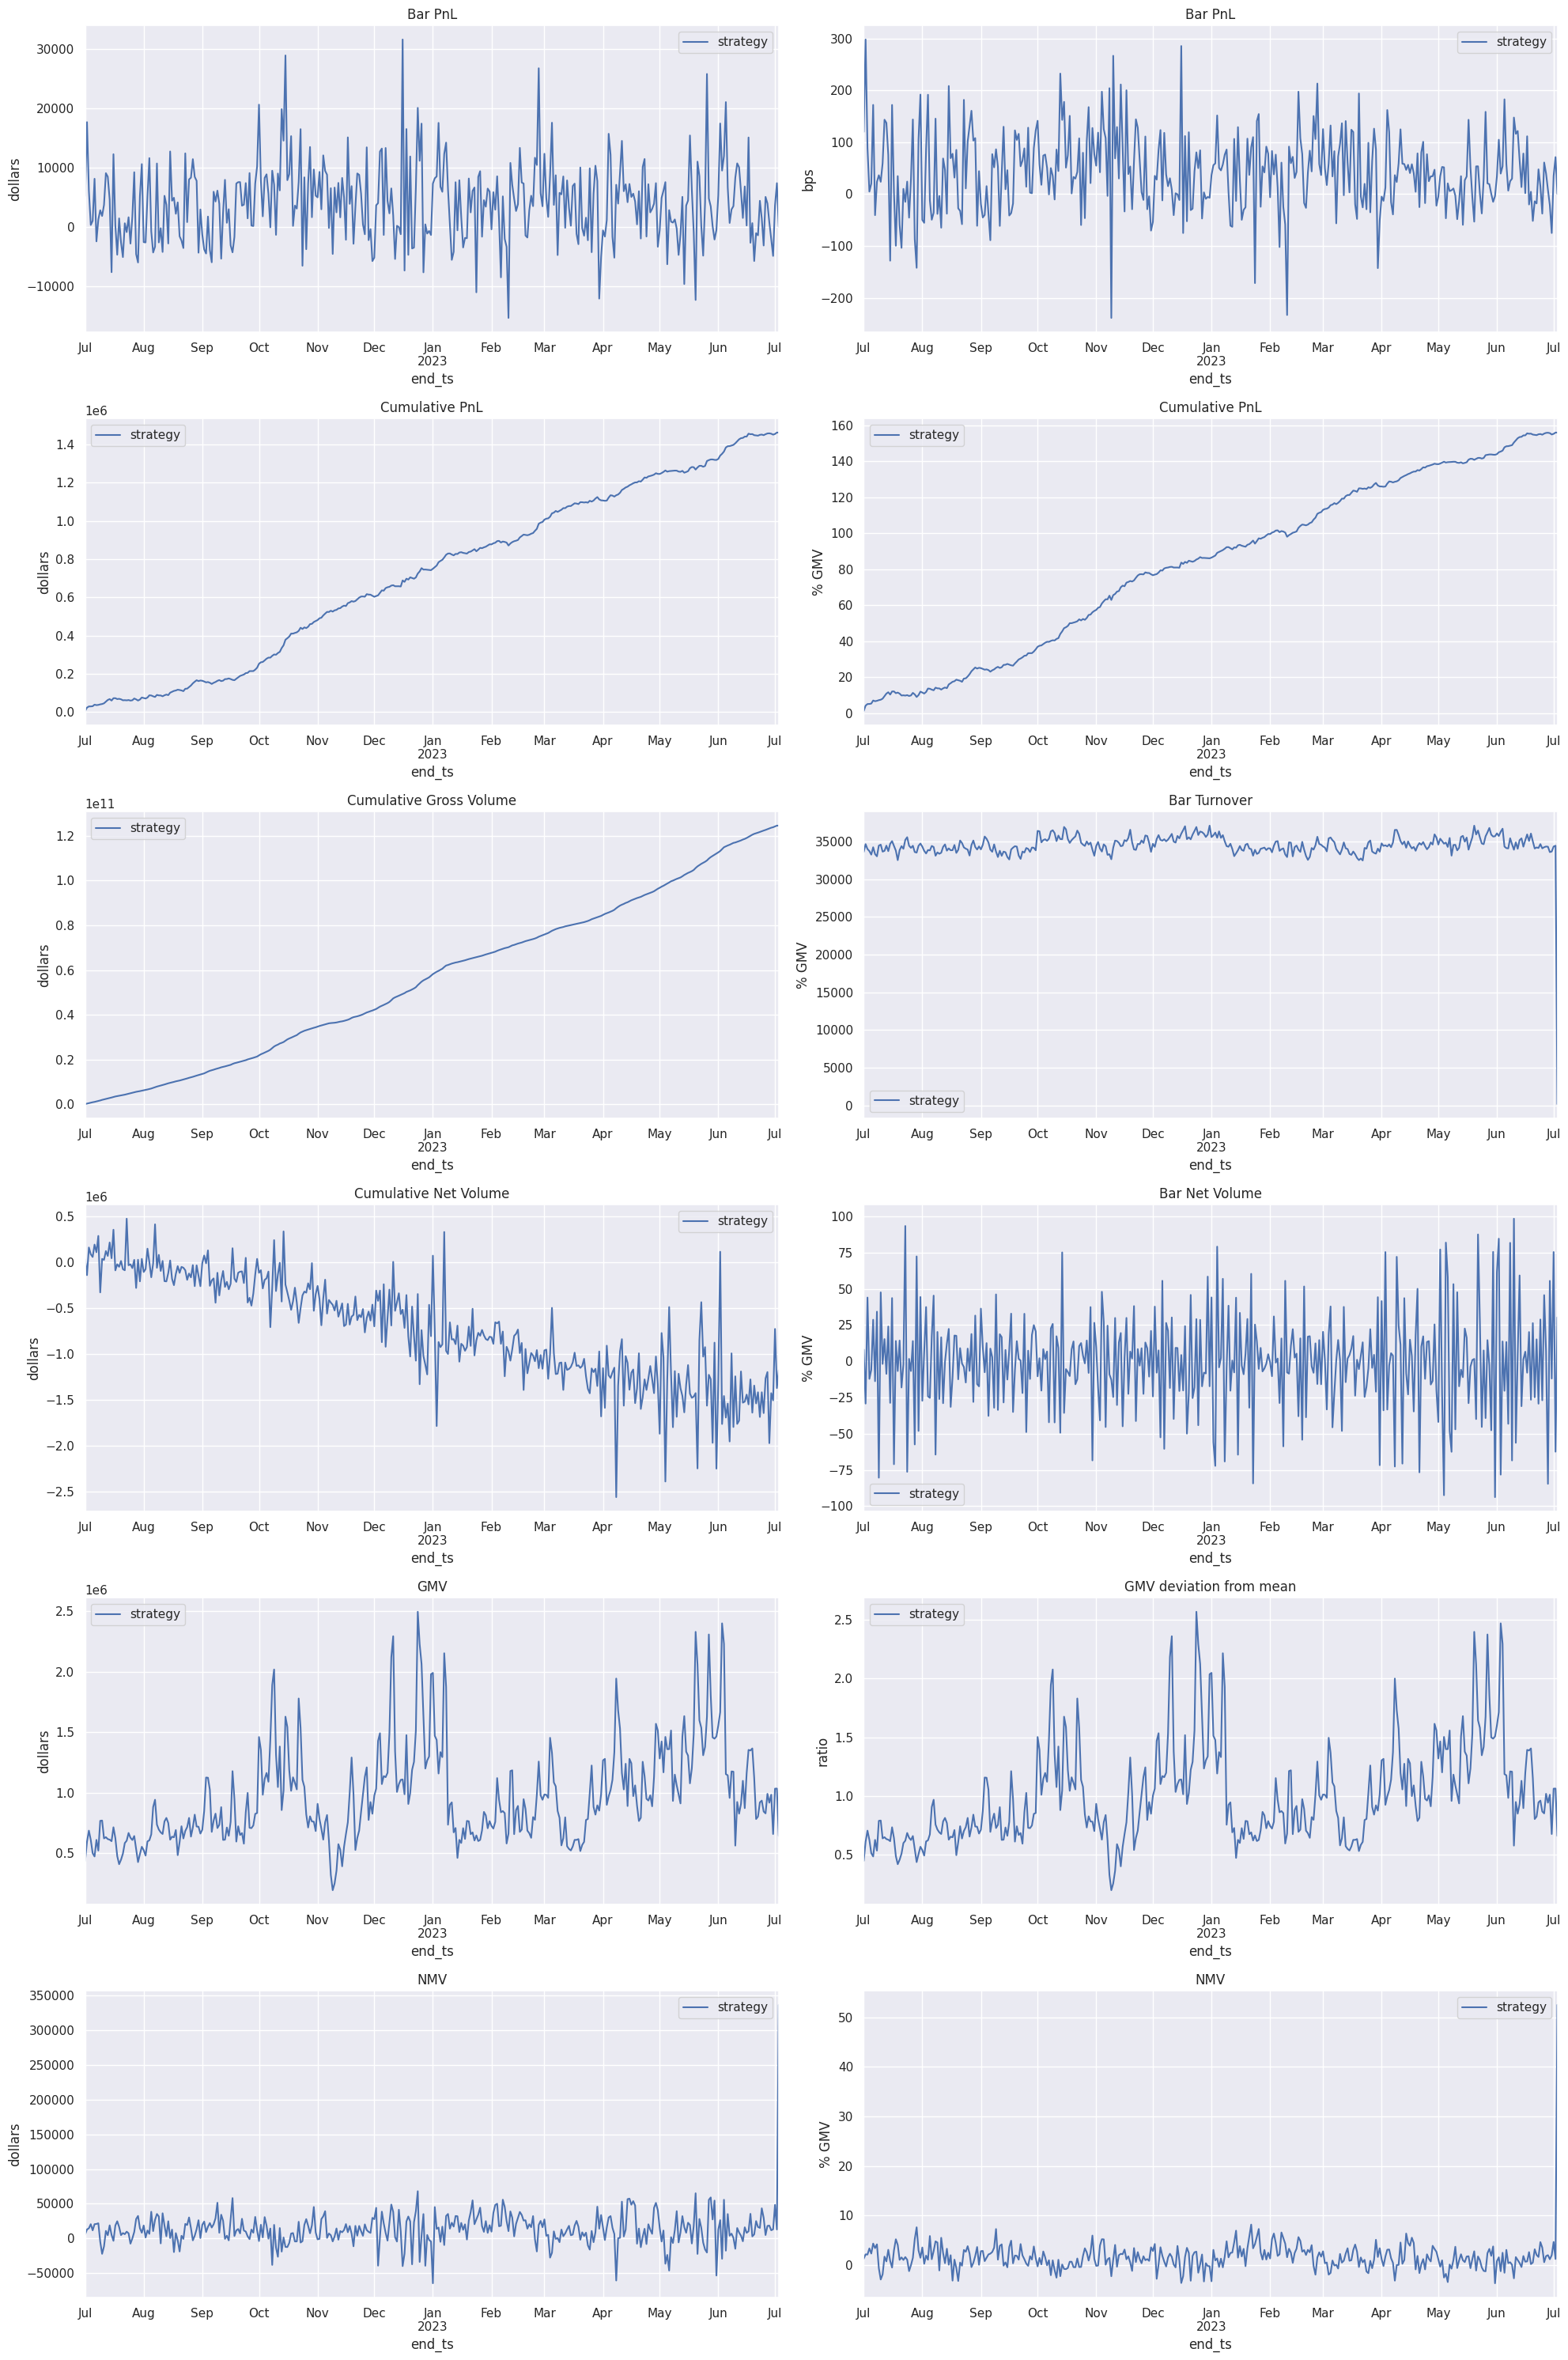

In [19]:
coplotti.plot_portfolio_stats(
    bar_metrics, freq=config["pnl_resampling_frequency"]
)

# Sanity check portfolio

In [20]:
# Check that the PnL is computed correctly by computing it in different ways
# and comparing to the reference one.
# Use the smallest correlation accross instruments to detect an error.
dtfmod.cross_check_portfolio_pnl(portfolio_df).min()

reference_pnl                                   1.0
holdings_notional_diff_minus_trades_notional    1.0
holdings_times_price_diff                       1.0
holdings_notional_minus_trade_times_price       1.0
holdings_notional_times_pct_price_change        1.0
dtype: float64

# Load the asset ids to full symbols mapping

In [21]:
vendor = "CCXT"
mode = "trade"
full_symbols = ivcu.get_vendor_universe(
    vendor, mode, version="v7.1", as_full_symbol=True
)
asset_id_to_full_symbol = ivcu.build_numerical_to_string_id_mapping(full_symbols)
asset_id_to_full_symbol

{6051632686: 'binance::APE_USDT',
 8717633868: 'binance::AVAX_USDT',
 2540896331: 'binance::AXS_USDT',
 1528092593: 'binance::BAKE_USDT',
 8968126878: 'binance::BNB_USDT',
 1467591036: 'binance::BTC_USDT',
 2476706208: 'binance::CRV_USDT',
 5115052901: 'binance::CTK_USDT',
 3065029174: 'binance::DOGE_USDT',
 1891737434: 'binance::DOT_USDT',
 3401245610: 'binance::DYDX_USDT',
 1464553467: 'binance::ETH_USDT',
 1966583502: 'binance::FTM_USDT',
 1030828978: 'binance::GMT_USDT',
 2601760471: 'binance::LINK_USDT',
 2683705052: 'binance::MATIC_USDT',
 9872743573: 'binance::NEAR_USDT',
 2484635488: 'binance::OGN_USDT',
 2099673105: 'binance::RUNE_USDT',
 4516629366: 'binance::SAND_USDT',
 2237530510: 'binance::SOL_USDT',
 2425308589: 'binance::STORJ_USDT',
 1776791608: 'binance::UNFI_USDT',
 2384892553: 'binance::WAVES_USDT',
 5118394986: 'binance::XRP_USDT'}

# Sanity check PnL vs target positions

In [22]:
universe_version = "v7.1"
vendor = "CCXT"
mode = "trade"
# Get asset ids.
asset_ids = ivcu.get_vendor_universe_as_asset_ids(universe_version, vendor, mode)
# Get prod `MarketData`.
market_data = dtfamsysc.get_Cx_RealTimeMarketData_prod_instance1(asset_ids)
# Load and resample OHLCV data.
start_timestamp = portfolio_df.index.min()
end_timestamp = portfolio_df.index.max()
_LOG.info(
    "start_timestamp=%s, end_timestamp=%s",
    start_timestamp,
    end_timestamp,
)
bar_duration = "5T"
ohlcv_df = dtfamsysc.load_and_resample_ohlcv_data(
    market_data,
    start_timestamp,
    end_timestamp,
    bar_duration,
)
# Convert to UTC to match the timezone from the research portfolio.
ohlcv_df.index = ohlcv_df.index.tz_convert("UTC")
ohlcv_df.tail(3)

INFO  Unable to fetch DB credentials from environment variables: 
	'POSTGRES_HOST'
	Attempting env file method.
INFO  Unable to fetch DB credentials from env file: 
	
################################################################################
* Failed assertion *
File '/app/amp/im_v2/devops/env/prod.im_db_config.env' doesn't exist
################################################################################

	Attempting AWS SecretsManager method.
INFO  Fetching secret: prod.im_data_db.read_only
INFO  Created prod DB connection: 
 None


/app/amp/helpers/hsql_implementation.py:582: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


INFO  start_timestamp=2022-07-01 00:00:00+00:00, end_timestamp=2023-07-03 00:00:00+00:00
INFO  fit_intervals=[(Timestamp('2022-07-01 00:00:00+0000', tz='UTC', freq='5T'), Timestamp('2023-07-03 00:00:00+0000', tz='UTC', freq='5T'))]


/app/amp/helpers/hsql_implementation.py:582: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


close                                                                                                                                                                                                                                                                               high                                                                                                                                                                                                                                                                                low                                                                                                                                                                                                                                                                               open                                                                                                                                      \
                          1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488   
end_timestamp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
2023-07-02 23:50:00+00:00     0.2281    1931.20    30569.5     0.1143      3.419      5.482     0.3117      1.070     19.417     1.8820     0.3342      0.760     0.0823      6.262      6.518     0.6797    0.06787      2.119     0.4466     0.6283     0.4835      2.169     13.068     245.48      1.463     0.2287    1935.11    30598.9     0.1145      3.427      5.494     0.3125      1.070     19.464     1.8882     0.3357      0.763     0.0826      6.274      6.529     0.6808    0.06800      2.124     0.4473     0.6289     0.4847      2.177     13.119     245.90      1.466     0.2280    1930.20    30561.8     0.1143      3.418      5.477     0.3114      1.068     19.380     1.8809     0.3342      0.759     0.0823      6.254      6.513     0.6790    0.06783      2.116     0.4461     0.6281     0.4835      2.168     13.068     245.42      1.462     0.2287    1934.63    30598.8     0.1144      3.425      5.493     0.3125      1.070     19.462     1.8864     0.3356      0.762     0.0824   
2023-07-02 23:55:00+00:00     0.2286    193

In [23]:
# Make sure that the prices from the real-time databases match the ones
# from the research portfolio.
# TODO(Grisha): eventually understand why the correlation is not perfect,
# probably due to prices updates after the fact.
ohlcv_df["vwap"].diff().corrwith(portfolio_df["price"].diff())

1030828978    0.999997
1464553467    0.999999
1467591036    0.999999
1528092593    0.999999
1776791608    0.999999
1891737434    0.999996
1966583502    0.999995
2099673105    0.999998
2237530510    0.999999
2384892553    0.999996
2425308589    0.999997
2476706208    0.999999
2484635488    0.999997
2540896331    0.999999
2601760471    1.000000
2683705052    0.999997
3065029174    0.999998
3401245610    0.999976
4516629366    0.999999
5115052901    0.999997
5118394986    0.999999
6051632686    0.999997
8717633868    0.999995
8968126878    0.999999
9872743573    0.999998
dtype: float64

In [24]:
# Re-compute the PnL using prices from the DB. For some reason the DB data
# starts at `2022-01-08 19:05:00-05:00` and there are small differences between
# the prices used to compute the Portfolio (Parquet data) vs the DB prices.
holdings_shares = portfolio_df["holdings_shares"].loc[
    "2022-01-08 19:05:00-05:00":
]
new_pnl = holdings_shares.shift(1).multiply(ohlcv_df["vwap"].diff())
# Check that the re-computed PnL matches the one from the research Portfolio.
new_pnl.corrwith(portfolio_df["pnl"].loc["2022-01-08 19:05:00-05:00":])

asset_id
1030828978    0.999998
1464553467    0.999999
1467591036    0.999999
1528092593    0.999999
1776791608    0.999998
1891737434    0.999995
1966583502    0.999993
2099673105    0.999998
2237530510    0.999995
2384892553    0.999989
2425308589    0.999992
2476706208    0.999995
2484635488    0.999994
2540896331    0.999998
2601760471    0.999998
2683705052    0.999996
3065029174    0.999994
3401245610    0.999978
4516629366    0.999999
5115052901    0.999999
5118394986    0.999998
6051632686    0.999995
8717633868    0.999993
8968126878    0.999998
9872743573    0.999993
dtype: float64

# Save data

## Target holdings shares

In [25]:
idx_name = portfolio_df["holdings_shares"].index.name
target_holdings_shares = (
    portfolio_df["holdings_shares"].shift(-1).stack().reset_index()
)
# Map asset ids to fulls symbols.
target_holdings_shares["full_symbol"] = target_holdings_shares["asset_id"].apply(
    lambda x: asset_id_to_full_symbol[x]
)
# Rename the column.
target_holdings_shares = target_holdings_shares.rename(
    columns={0: "target_holdings_shares"}
)
# Keep only the relevant columns.
target_holdings_shares = target_holdings_shares[
    [idx_name, "full_symbol", "target_holdings_shares"]
]
_LOG.info("df.shape=%s", target_holdings_shares.shape)
target_holdings_shares.tail(10)

INFO  df.shape=(2642275, 3)


,end_ts,full_symbol,target_holdings_shares
2642265,2023-07-02 23:55:00+00:00,binance::MATIC_USDT,-41925.00
2642266,2023-07-02 23:55:00+00:00,binance::DOGE_USDT,658563.00
2642267,2023-07-02 23:55:00+00:00,binance::DYDX_USDT,-7381.00
2642268,2023-07-02 23:55:00+00:00,binance::SAND_USDT,66283.00
2642269,2023-07-02 23:55:00+00:00,binance::CTK_USDT,41561.00
2642270,2023-07-02 23:55:00+00:00,binance::XRP_USDT,83191.60
2642271,2023-07-02 23:55:00+00:00,binance::APE_USDT,13816.00
2642272,2023-07-02 23:55:00+00:00,binance::AVAX_USDT,1921.00
2642273,2023-07-02 23:55:00+00:00,binance::BNB_USDT,-34.39
2642274,2023-07-02 23:55:00+00:00,binance::NEAR_USDT,14538.00


In [32]:
if config["save_data"]:
    target_holdings_shares_path = os.path.join(
        config["save_data_dst_dir"], "target_holdings_shares.csv.gz"
    )
    target_holdings_shares.to_csv(target_holdings_shares_path, index=False)
    tmp = pd.read_csv(target_holdings_shares_path)
    _LOG.info("df.shape=%s", tmp.shape)
    tmp.tail(10)

## PnL

In [29]:
pnl_df = portfolio_df["pnl"].stack().reset_index()
# Mapp asset ids to fulls symbols.
pnl_df["full_symbol"] = pnl_df["asset_id"].apply(
    lambda x: asset_id_to_full_symbol[x]
)
# Rename.
pnl_df = pnl_df.rename(columns={0: "pnl"})
# Keep only the relevant columns.
pnl_df = pnl_df[["end_ts", "full_symbol", "pnl"]]
_LOG.info("df.shape=%s", pnl_df.shape)
pnl_df.tail(10)

INFO  df.shape=(2642275, 3)


,end_ts,full_symbol,pnl
2642265,2023-07-03 00:00:00+00:00,binance::MATIC_USDT,17.344192
2642266,2023-07-03 00:00:00+00:00,binance::DOGE_USDT,11.890363
2642267,2023-07-03 00:00:00+00:00,binance::DYDX_USDT,18.250914
2642268,2023-07-03 00:00:00+00:00,binance::SAND_USDT,3.109965
2642269,2023-07-03 00:00:00+00:00,binance::CTK_USDT,39.898805
2642270,2023-07-03 00:00:00+00:00,binance::XRP_USDT,-24.416952
2642271,2023-07-03 00:00:00+00:00,binance::APE_USDT,-10.969579
2642272,2023-07-03 00:00:00+00:00,binance::AVAX_USDT,35.420011
2642273,2023-07-03 00:00:00+00:00,binance::BNB_USDT,12.351380
2642274,2023-07-03 00:00:00+00:00,binance::NEAR_USDT,-16.980969


In [33]:
if config["save_data"]:
    pnl_path = os.path.join(config["save_data_dst_dir"], "pnl.csv.gz")
    pnl_df.to_csv(pnl_path, index=False)
    tmp = pd.read_csv(pnl_path)
    _LOG.info("df.shape=%s", tmp.shape)
    tmp.tail(10)